# TP 2 - Organizacion de Datos

## Oh La La... Data!

* **Hamma AALI CHTOUKI** --- *Padrón 106607 - Alumno regular de intercambio.*  
* **Aymeryc COUSAERT** ------  *Padrón 105464 - Alumno regular de intercambio.*
* **Mariana VINYOLAS**  ---------  *Alumna oyente.*

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
import re
import nltk.corpus
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Importamos el dataset

Hacemos ademas un procesamiento del texto para eliminar stopwords y caracteres

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('train.csv')

In [4]:
df['text'] = df['text'].str.lower()

def clean_str(string):
    string = re.sub(r'https?\://\S+', '', string)
    string = re.sub(r'http?\://\S+', '', string)
    string = re.sub(r'@\w*\s', '', string)
    string = re.sub(r'#\w*\s', '', string)
    string = re.sub(r'\d', '', string)
    return string

df['text_clean'] = df['text'].apply(lambda x: clean_str(str(x)))

In [5]:
# eliminamos stopwords
stop = stopwords.words('english')

df['text_clean'] = df['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# eliminamos signos de puntuacion y caracteres especiales
df['text_clean'] = df['text_clean'].str.replace('[^\w\s]','')

In [6]:
pd.set_option('display.max_colwidth', 100)

In [7]:
df[['text', 'text_clean']].sample(5)

,text,text_clean
1413,@alcoholandmetal + do anything to fix that. of the few people he had every trusted in his life c...,anything fix that people every trusted life charles one casualties
653,property losses from california wildfire nearly double as week-old blaze rages http://t.co/e0uus...,property losses california wildfire nearly double weekold blaze rages
1271,always look for the silver lining! \n\nmy barn having burned to the ground\ni can now see the m...,always look silver lining barn burned ground see moon mizuta
6363,#bestnaijamade: 16yr old pkk suicide bomber who detonated bomb in ... http://t.co/ksawlyux02 bes...,bestnaijamade yr old pkk suicide bomber detonated bomb bestnaijamade bestnaijamade bestnaijamad...
5195,we destroyed the #zimmerman fan club on twitter @rzimmermanjr and we obliterated renewsit reduce...,destroyed fan club twitter obliterated renewsit reduced sock acc


In [8]:
X = df['text_clean'].values 
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)      

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5329,), (2284,), (5329,), (2284,))

In [9]:
vocab_size = 80000
# vocab_size = len(word_index)+1
embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>" 

In [10]:

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index

In [11]:
# Pad sequences with zeros
X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)

## Entrenamos una red neuronal con Embedding


In [12]:
# instanciamos el modelo
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.GlobalMaxPooling1D(),
#     tf.keras.layers.Conv1D( filters=5 ,kernel_size=5, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True) ,optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          10240000  
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               12900     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 10,253,001
Trainable params: 10,253,001
Non-trainable params: 0
____________________________________________

In [13]:
num_epochs = 5
batch_size = 30
history = model.fit(X_train, y_train, epochs=num_epochs,
                    batch_size=batch_size,validation_data=(X_test, y_test))

Epoch 1/5
178/178 [==============================] - 43s 242ms/step - loss: 0.6823 - accuracy: 0.5701 - val_loss: 0.6786 - val_accuracy: 0.5709
Epoch 2/5
178/178 [==============================] - 32s 180ms/step - loss: 0.6576 - accuracy: 0.5720 - val_loss: 0.6146 - val_accuracy: 0.5933
Epoch 3/5
178/178 [==============================] - 32s 177ms/step - loss: 0.5053 - accuracy: 0.7187 - val_loss: 0.4844 - val_accuracy: 0.7872
Epoch 4/5
178/178 [==============================] - 31s 175ms/step - loss: 0.3582 - accuracy: 0.8377 - val_loss: 0.4810 - val_accuracy: 0.7925
Epoch 5/5
178/178 [==============================] - 32s 179ms/step - loss: 0.2854 - accuracy: 0.8758 - val_loss: 0.4824 - val_accuracy: 0.8017


## Visualizacion del training


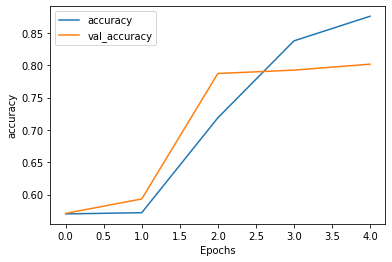

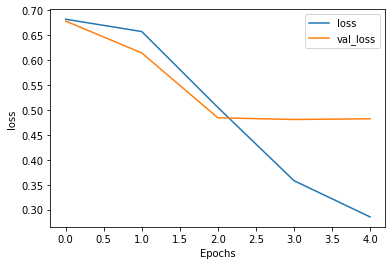

In [14]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [15]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8921
Testing Accuracy:  0.8017


## Predicciones en el test set

Procesamos el dataset **test** para predecir sus labels

In [16]:
test = pd.read_csv('test.csv')

test['text'] = test['text'].str.lower()

def clean_str(string):
    string = re.sub(r'https?\://\S+', '', string)
    string = re.sub(r'http?\://\S+', '', string)
    string = re.sub(r'@\w*\s', '', string)
    string = re.sub(r'#\w*\s', '', string)
    string = re.sub(r'\d', '', string)
    return string

test['text_clean'] = test['text'].apply(lambda x: clean_str(str(x)))



stop = stopwords.words('english')

test['text_clean'] = test['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# eliminamos signos de puntuacion y caracteres especiales
test['text_clean'] = test['text_clean'].str.replace('[^\w\s]','')

In [17]:
test[['text', 'text_clean']].sample(5)

,text,text_clean
2789,think it's actually sunk in that we've left school ??????????,think actually sunk weve left school
2930,loving you was like throwing a lasso around a tornado i tried to hold on to.??,loving like throwing lasso around tornado tried hold to
3103,t shirts $10 male or female get wit me. 2 days until its game changin time. war zone single will...,shirts male female get wit me days game changin time war zone single beû_
289,@_afrojazz i'll add you (i dont even know what you talking about),ill add i dont even know talking about
2068,#fromthedesk of king george kenyatta muumbo at the kings african citizens\n\nthanks to #quantumd...,king george kenyatta muumbo kings african citizens thanks we


In [18]:
test_tweets = test['text_clean'].tolist()

# Creamos las sequencias
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(test_tweets)
test_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)           
    
classes = model.predict_classes(test_padded)


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [19]:
classes

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])